# FOMO - Faster Objects, More Objects

## Common

#### Import modules

In [108]:
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from torchmetrics import MetricCollection
from torchmetrics.classification import BinaryAccuracy, BinaryRecall, BinaryPrecision, BinaryF1Score

import pytorch_lightning as pl
from pytorch_lightning.loggers import MLFlowLogger

from monai.losses.dice import DiceLoss

#### Constants

In [153]:
DATASET_DIR = Path("../cars_dataset_split")

IMAGE_RESOLUTION = 224
GRID_SCALE = 8
NUMBER_OF_CLASSES = 1

NUMBER_OF_EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

DETECTION_THRESHOLD = 0.1

#### BoundingBoxToMask

In [110]:
class BoundingBoxToMask:
    """
    Convert YOLO bounding boxes to FOMO centroids. 
    Used in label processing.
    """
    def __init__(self, image_resolution: int, grid_scale: int, number_of_classes: int):
        self._image_resolution = image_resolution
        self._grid_scale = grid_scale
        self._number_of_classes = number_of_classes

    def __call__(self, label):
        grid_resolution = int(self._image_resolution / self._grid_scale)

        masks = []
        for i in range(self._number_of_classes):
            class_mask = torch.zeros((grid_resolution, grid_resolution), dtype=float)
            bounding_boxes = label.readlines()
            for bounding_box in bounding_boxes:
                [c, x, y, _, _] = [
                    float(coords) for coords in bounding_box.split()
                ]  # get bounding box class, position and dimension
                if c == i:
                    x = int(x * grid_resolution)
                    y = int(y * grid_resolution)
                    class_mask[y, x] = 1.0

            masks.append(class_mask)
        return torch.stack(masks)

#### Dataset

In [111]:
class VehicleDataset(Dataset):
    def __init__(
        self,
        dataset_dir: Path,
        transform=None,
        target_transform=None,
    ):
        self._images = sorted([
            element for element in (dataset_dir / Path("images")).iterdir()
        ])
        self._bounding_boxes = sorted([
            element for element in (dataset_dir / Path("labels/bounding_boxes")).iterdir()
        ])
        self._transform = transform
        self._target_transform = target_transform

    def __getitem__(self, idx: int):
        image_path = self._images[idx]
        image = read_image(str(image_path))
        image = self._transform(image.float())

        bounding_box_path = self._bounding_boxes[idx]
        bounding_box_file = open(bounding_box_path)
        mask = self._target_transform(bounding_box_file)

        return image, mask

    def __len__(self):
        return len(self._images)

#### DataModule

In [112]:
class VehicleDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset_dir: Path,
        input_resolution: int,
        grid_scale: int,
        batch_size: int,
    ):
        super().__init__()
        self._dataset_dir = dataset_dir
        self._input_resolution = input_resolution  # model input image resolution (assume input is squared shape)
        self._grid_scale = grid_scale  # number of pixels per cell on prediction grid (vertically and horizontally)
        self._batch_size = batch_size

        self._transform = Resize((input_resolution, input_resolution), antialias=True)
        self._target_transform = BoundingBoxToMask(input_resolution, grid_scale, 1)
        self._train_dataset = None
        self._val_dataset = None

    def setup(self, stage: str):
        self._train_dataset = VehicleDataset(
            self._dataset_dir / Path("training"),
            self._transform,
            self._target_transform,
        )
        self._val_dataset = VehicleDataset(
            self._dataset_dir / Path("validation"),
            self._transform,
            self._target_transform,
        )

    def train_dataloader(self):
        return DataLoader(self._train_dataset, batch_size=self._batch_size, num_workers=7)

    def val_dataloader(self):
        return DataLoader(self._val_dataset, batch_size=self._batch_size, num_workers=7)

In [113]:
vehicle_data_module = VehicleDataModule(
    dataset_dir=DATASET_DIR,
    input_resolution=IMAGE_RESOLUTION,
    grid_scale=GRID_SCALE,
    batch_size=BATCH_SIZE,
)

#### FOMO network architecture

In [114]:
def fomo_net(weights: None, number_of_classes: int) -> nn.Module:
    """
    Constructs a FOMO net model with a specified number of classes.
    Input resolution is decreased by a factor of 8.
    """
    model = mobilenet_v2(weights=weights)

    # Remove layers after 1/8 reduction
    cut_inverted_residual = 7
    features = [
        nn.Identity() if i > cut_inverted_residual else model.features[i]
        for i, _ in enumerate(model.features)
    ]
    features[cut_inverted_residual].conv[1] = nn.Identity()
    features[cut_inverted_residual].conv[2] = nn.Identity()
    features[cut_inverted_residual].conv[3] = nn.Identity()
    model = nn.Sequential(*features)
    
    # Add classification layers
    model.classifier = nn.Sequential(
        nn.Conv2d(
            in_channels=192, 
            out_channels=32, 
            kernel_size=1, 
            stride=1),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=32,
            out_channels=number_of_classes,
            kernel_size=1,
            stride=1,
        ),
    )    
    return model

#### Funtion to postprocess the mask generated by FOMO

In [115]:
def postprocess_fomo_mask_prediction(
    mask_pred: torch.Tensor, threshold: float, binary: bool=True, connected: bool=True
) -> torch.Tensor:
    """
    Postprocesses FOMO mask prediction to squish output between [0:1] and remove multiple detections of the same object
    """
    mask_pred = torch.sigmoid(mask_pred)
    for single_mask_pred in mask_pred.unbind(0):
        for i, channel in enumerate(single_mask_pred.unbind(0)):
            channel = channel.numpy()
            if binary:
                binary_channel = np.where(channel > threshold, 1.0, 0.0).astype(np.int8)
            else:
                binary_channel = channel
            if connected:
                number_of_blobs, blobs = cv2.connectedComponentsWithAlgorithm(
                    binary_channel,
                    connectivity=8,
                    ltype=cv2.CV_32S,
                    ccltype=cv2.CCL_WU,
                )
                binary_channel.fill(0)
                for blob in range(1, number_of_blobs):
                    blob_mask = (blobs == blob)
                    max_val = np.max(channel[blob_mask])
                    channel_max = np.where((channel == max_val), 1, 0)
                    binary_channel += np.logical_and(channel_max, blob_mask)

            single_mask_pred[i] = torch.from_numpy(binary_channel)
    return mask_pred

#### LightningModule

In [116]:
class FomoModule(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self._network = fomo_net(
            weights=MobileNet_V2_Weights.DEFAULT,
            number_of_classes=NUMBER_OF_CLASSES,
        )
        self._loss_function = DiceLoss(sigmoid=True)
 
        metrics = MetricCollection([
            BinaryAccuracy(),
            BinaryF1Score(),
            BinaryRecall(),
            BinaryPrecision()
        ])
        self.train_metrics = metrics.clone(prefix='train_')
        self.valid_metrics = metrics.clone(prefix='val_')

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self._network(inputs)

    def training_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)

        mask_pred = postprocess_fomo_mask_prediction(
            mask_pred.detach().cpu(), threshold=DETECTION_THRESHOLD
        )
        self.log("train_loss", loss, prog_bar=True)
        metric = self.train_metrics(mask_pred.cuda(), mask)
        self.log_dict(metric)
        return loss

    def validation_step(self, batch, batch_idx):
        image, mask = batch
        mask_pred = self(image)
        loss = self._loss_function(mask_pred, mask)

        mask_pred = postprocess_fomo_mask_prediction(
            mask_pred.detach().cpu(), threshold=DETECTION_THRESHOLD
        )
        self.log("valid_loss", loss, prog_bar=True)
        metric = self.valid_metrics(mask_pred.cuda(), mask)
        self.log_dict(metric)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)

## Training

#### Training function

In [117]:
def fomo_train():
    fomo_module = FomoModule()

    mlflow_logger = MLFlowLogger(
        experiment_name="FOMO",
        run_name="test",
        tracking_uri="http://127.0.0.1:8080",
        log_model=True
    )
    trainer = pl.Trainer(
        max_epochs=NUMBER_OF_EPOCHS,
        logger=mlflow_logger,
        log_every_n_steps=10
    )
    
    trainer.fit(model=fomo_module, datamodule=vehicle_data_module)

#### Train

In [118]:
fomo_train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type             | Params
----------------------------------------------------
0 | _network       | Sequential       | 68.2 K
1 | _loss_function | DiceLoss         | 0     
2 | train_metrics  | MetricCollection | 0     
3 | valid_metrics  | MetricCollection | 0     
----------------------------------------------------
68.2 K    Trainable params
0         Non-trainable params
68.2 K    Total params
0.273     Total estimated model params size (MB)


Epoch 9: 100%|██████████| 54/54 [00:41<00:00,  1.30it/s, v_num=c4e0, train_loss=0.0223, valid_loss=0.180] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 54/54 [00:41<00:00,  1.30it/s, v_num=c4e0, train_loss=0.0223, valid_loss=0.180]


## Testing

### Inspect dataset images and masks

1 object(s) in the picture


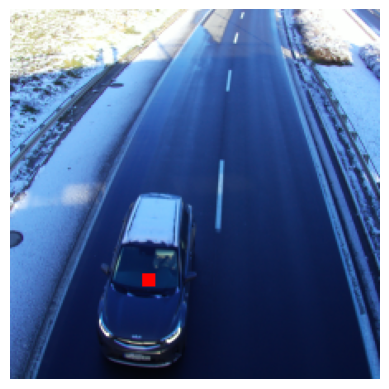

In [119]:
def inspect_dataset(data_idx: int, class_idx: int):
    dataset = VehicleDataset(
                DATASET_DIR / Path("training"),
                Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION), antialias=True),
                BoundingBoxToMask(IMAGE_RESOLUTION, GRID_SCALE, 1))
    image = dataset[data_idx][0]
    mask = dataset[data_idx][1][class_idx]
    image = image.permute(1, 2, 0).numpy().astype(int)
    mask_res = cv2.resize(
        mask.numpy(),
        dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
        interpolation=cv2.INTER_NEAREST,
    )
    image[mask_res == 1] = [255, 0, 0]
    plt.axis('off')
    plt.imshow(image)

    cnt = np.count_nonzero(mask)
    print(str(cnt), "object(s) in the picture")

inspect_dataset(data_idx=27, class_idx=0)

### Test trained model

3 objects in the picture


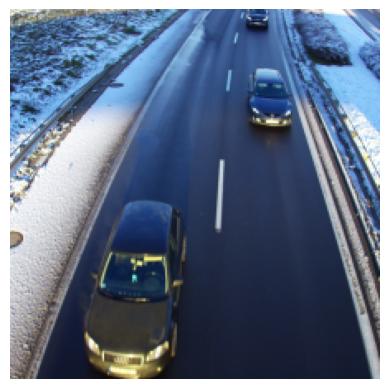

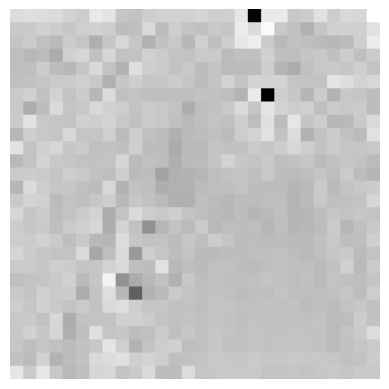

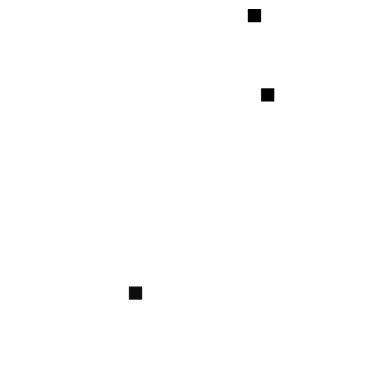

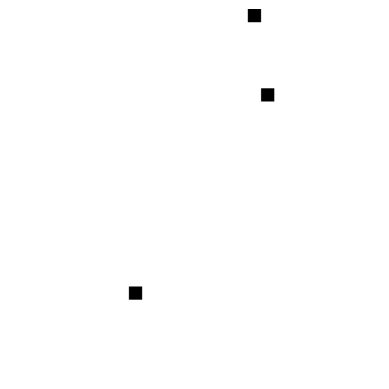

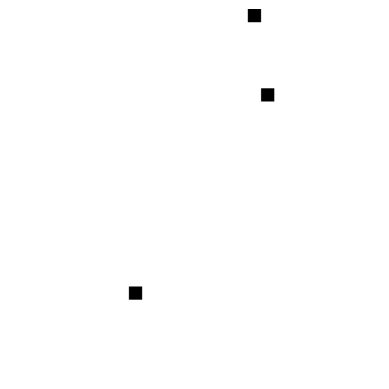

In [173]:
def display_mask(mask: torch.Tensor):
    mask = mask.squeeze(0).permute(1, 2, 0).numpy()
    mask_res = cv2.resize(
        mask,
        dsize=(IMAGE_RESOLUTION, IMAGE_RESOLUTION),
        interpolation=cv2.INTER_NEAREST,
    )
    plt.figure()
    plt.axis('off')
    plt.imshow(mask_res, cmap='binary')

def test_model(model_path: str, data_idx: int, mask_idx: int, threshold: float):
    dataset = VehicleDataset(
                DATASET_DIR / Path("validation"),
                Resize((IMAGE_RESOLUTION, IMAGE_RESOLUTION), antialias=True),
                BoundingBoxToMask(IMAGE_RESOLUTION, GRID_SCALE, 1))
    image = dataset[data_idx][0]
    plt.axis('off')
    plt.imshow(image.permute(1, 2, 0).numpy().astype(int))

    model = FomoModule.load_from_checkpoint(model_path)
    with torch.no_grad():
        model.eval()
        mask_pred = model(image.unsqueeze(0).cuda()).cpu()
        mask_post_sig = postprocess_fomo_mask_prediction(mask_pred, threshold=threshold, binary=False, connected=False)
        mask_post_bin = postprocess_fomo_mask_prediction(mask_pred, threshold=threshold, binary=True, connected=False)
        mask_post_con = postprocess_fomo_mask_prediction(mask_pred, threshold=threshold, binary=True, connected=True)
    
    display_mask(mask_pred)
    display_mask(mask_post_sig)
    display_mask(mask_post_bin)
    display_mask(mask_post_con)

    cnt = np.count_nonzero(mask_post_con)
    print(str(cnt), "objects in the picture")

test_model(model_path="399010269064744334/56634d5296d1445793f845250bb3c4e0/checkpoints/epoch=9-step=540.ckpt",
           data_idx=27, mask_idx=0, threshold=DETECTION_THRESHOLD)

## Export

In [ ]:
def export_fomo_model():
    model = FomoModule.load_from_checkpoint(
        "399010269064744334/56634d5296d1445793f845250bb3c4e0/checkpoints/epoch=9-step=540.ckpt"
    )

    model.to_onnx(
        "fomo.onnx",
        export_params=True,
        input_names=["image"],
        output_names=["masks"],
        input_sample=torch.randn(1, 3, IMAGE_RESOLUTION, IMAGE_RESOLUTION),
    )

export_fomo_model()